In [1]:
from fase.RF.sktree import TumorRF
import pickle
import numpy as np
from fase.hnrf.preprocessing import Featurizer

Using CPU version HEAAN


In [2]:
#if __name__=="__main__":
data_dir = "/home/hoseung/Dropbox/DeepInsight/2021ETRI/RF_Tumor_Classification/data/"

# Init TumorRf class
# Pre-defined preprocessing steps are taken automatically. 
tumor_rf = TumorRF(data_dir)

# Split the data and keep validation data separately. 
X_train, X_valid, Y_train, Y_valid = tumor_rf.split_data(fn_dump="tumor_")

Preprocessing done and train data are ready
Saved Training set as tumor_train.pickle
Saved Validation set as tumor_valid.pickle


In [3]:
# Train the model
tumor_rf.train(X_train, Y_train, ntree=20, depth=7)

tumor_rf.save_model("tumor_trained_RF.pickle")

# Test the model against validation dataset.
y_preds = tumor_rf.predict(X_valid)

# Caculate validation performance 
tumor_rf.accuracy(Y_valid, y_preds)

#pickle.dump({"train_x":X_train, "train_y":Y_train}, open("trainset.pickle", "wb"))
pickle.dump(tumor_rf, open("whole_tumor_rf.pickle", "wb"))

Training a Random Forest with 20 trees of depth 7.
Trained model saved at: trained_RF.pickle
Train Done: train accuracy = 57.837%
Test accuracy 57.817%


In [4]:
X_train.max()

1.0

# Convert to Neural RF and finetune

In [2]:
rf_model = pickle.load(open("tumor_trained_RF.pickle", "rb"))

dd = pickle.load(open("tumor_train.pickle", "rb"))
X_train, y_train = dd['train_x'], dd['train_y']

dd = pickle.load(open("tumor_valid.pickle", "rb"))
X_valid, y_valid = dd['valid_x'], dd['valid_y']

In [3]:
print("min max of input dataset")
print(X_train.min(), X_train.max())
print(X_valid.min(), X_valid.max())

min max of input dataset
0.0 1.0
0.0 1.0


In [4]:
import torch
from sklearn.tree import BaseDecisionTree
from fase.hnrf.tree import NeuralRF
from fase.hnrf.tree import NeuralTreeMaker

dilatation_factor = 10
polynomial_degree = 10

#rf_model = tumor_rf#.rf
estimators = rf_model#.estimators_

my_tm_tanh = NeuralTreeMaker(torch.tanh, 
                            use_polynomial=True,
                            dilatation_factor=dilatation_factor, 
                            polynomial_degree=polynomial_degree)

Nmodel = NeuralRF(estimators, my_tm_tanh)

In [5]:
ind = slice(0,-1,1000)

# NRF 성능 테스트

with torch.no_grad():
    neural_pred = Nmodel(torch.tensor(X_train[ind]).float()).argmax(dim=1).numpy()
    
pred = rf_model.predict(X_train[ind])
print(f"Original accuracy : {(pred == y_train[ind]).mean()}")
print(f"Accuracy of tanh : {(neural_pred == y_train[ind]).mean()}")
print(f"Match between tanh and original : {(neural_pred == pred).mean()}")

Original accuracy : 0.5831295843520783
Accuracy of tanh : 0.3526894865525672
Match between tanh and original : 0.4712713936430318


## Fine tune

In [6]:
from torch.utils import data

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

In [7]:
bs = 128

train_ds = TabularDataset(X_train, y_train)
valid_ds = TabularDataset(X_valid, y_valid)

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)

In [8]:
import fastai
print(fastai.__version__)

from fastai.basic_data import DataBunch
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

from fase.hnrf.tree import CrossEntropyLabelSmoothing
import torch.nn as nn

data = DataBunch(train_dl, valid_dl, fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, Nmodel, loss_func=criterion, metrics=accuracy)

1.0.58


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


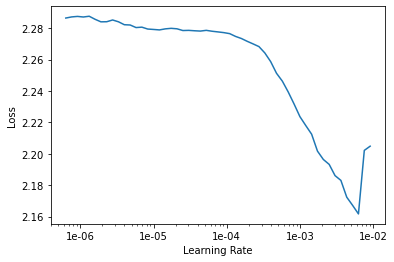

In [9]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
#learn.fit_one_cycle(10, 0.2)
learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time


In [14]:
pickle.dump(Nmodel, open("trained_Nmodel_RF.pickle", "wb"))

# FHE

In [13]:
import numpy as np
import pickle
import torch

from fase.core import heaan

from time import time
from fase import HEAAN as he
#from typing import List, Callable

from fase.hnrf.tree import NeuralTreeMaker
from fase.hnrf import heaan_nrf 
from fase.hnrf.hetree import HNRF

import importlib

class Param():
    def __init__(self, n=None, logn=None, logp=None, logq=None, logQboot=None):
        self.n = n
        self.logn = logn
        self.logp = logp
        self.logq = logq 
        self.logQboot = logQboot
        if self.logn == None:
            self.logn = int(np.log2(n))

class HNRF_builder():
    def __init__(self, Nmodel, do_reduction=False, device="cpu"):
        
        self._do_reduction = do_reduction
        logq = 540
        logp = 30
        logn = 14
        n = 1*2**logn
        parms = Param(n=n, logp=logp, logq=logq)

        self.parms = Param(n=n, logp=logp, logq=logq)
        self.ring = he.Ring()
        self.secretKey = he.SecretKey(self.ring)
        self.scheme = he.Scheme(self.secretKey, self.ring, False)
        self.algo = he.SchemeAlgo(self.scheme)
        
        # reduction때는 right rotation N_class개 필요. 
        Nclass = len(Nmodel.head_bias)
        if self._do_reduction:
            self.scheme.addLeftRotKeys(self.secretKey)
            for i in range(Nclass):
                self.scheme.addRightRotKey(self.secretKey, i+1) # 
        else:
            # reduction 안 하면 하나짜리 rotation만 여러번 반복.
            self.scheme.addLeftRotKey(self.secretKey, 1)

        Nmodel.to_device(device)
        self.construct_hnrf(Nmodel, device=device)
            
            
    def construct_hnrf(self, Nmodel, device="cpu"):
        t0 = time()
        h_rf = HNRF(Nmodel, device)
        self.nrf_evaluator = heaan_nrf.HETreeEvaluator.from_model(h_rf,
                                                            self.scheme,
                                                            self.parms,
                                                            Nmodel.activation.coef,
                                                            #self.my_tm_tanh.coeffs, dilated or not?
                                                            do_reduction = self._do_reduction,
                                                            )
        print(f"HNRF model is ready in {time() - t0:.2f}seconds")
        #allmodels.append((f"{action}",nrf_evaluator))
        self.featurizer = heaan_nrf.HETreeFeaturizer(h_rf.return_comparator(), self.scheme, self.parms)

    def predict(self, ctx):
        return self.nrf_evaluator(ctx)
    
    
    

In [15]:
tumor_hnrf = HNRF_builder(Nmodel, device="cpu")

CKKS paramters:
---------------------------
n = 16384
logp = 30
logq = 540
tanh activation polynomial coeffs = [ 5.046468e-17  1.263836e+00  5.235711e-17 -3.961554e-01  3.229740e-16  2.072633e-01  1.614870e-16 -1.145040e-01
  1.251524e-15  5.200031e-02  2.503048e-15]
tanh activation polynomial degree = 10

Neural RF
---------------------------

HNRF model is ready in 344.82seconds


In [16]:
def decrypt(context, enc):
    featurized = context.scheme.decrypt(context.secretKey, enc)
    arr = np.zeros(context.parms.n, dtype=np.complex128)
    featurized.__getarr__(arr)
    return arr.real

In [18]:
for xx, yy in zip(X_valid[:4], y_valid[:4]):
    ctx = tumor_hnrf.featurizer.encrypt(xx)
    t0 = time()
    result = tumor_hnrf.predict(ctx)
    print(f"Took {time() - t0:.2f} seconds")

    pred = []
    for res in result:
        dec = decrypt(tumor_hnrf, res)
        pred.append(np.sum(dec))

    print(f"Prediction: {np.argmax(pred)} == {yy}?")

KeyboardInterrupt: 